# "Walmart Recruiting - Store Sales Forecasting using Machine Learning"

"Discover how to predict Walmart's weekly sales using a range of Machine Learning models, including linear regression, decision trees, and ensemble methods. Begin by thoroughly examining the dataset, conducting Exploratory Data Analysis (EDA), applying feature engineering techniques, and preparing the data using essential libraries like Pandas, Numpy, Matplotlib, Seaborn, and Plotly. Next, assess model performance using the Weighted Mean Absolute Error (WMAE) metric, and employ hyperparameter tuning to identify the most effective model. Save the top-performing model, and conclude the project with a comprehensive summary of insights and lessons learned. This code can be executed seamlessly in Google Colab by simply clicking 'Run'."

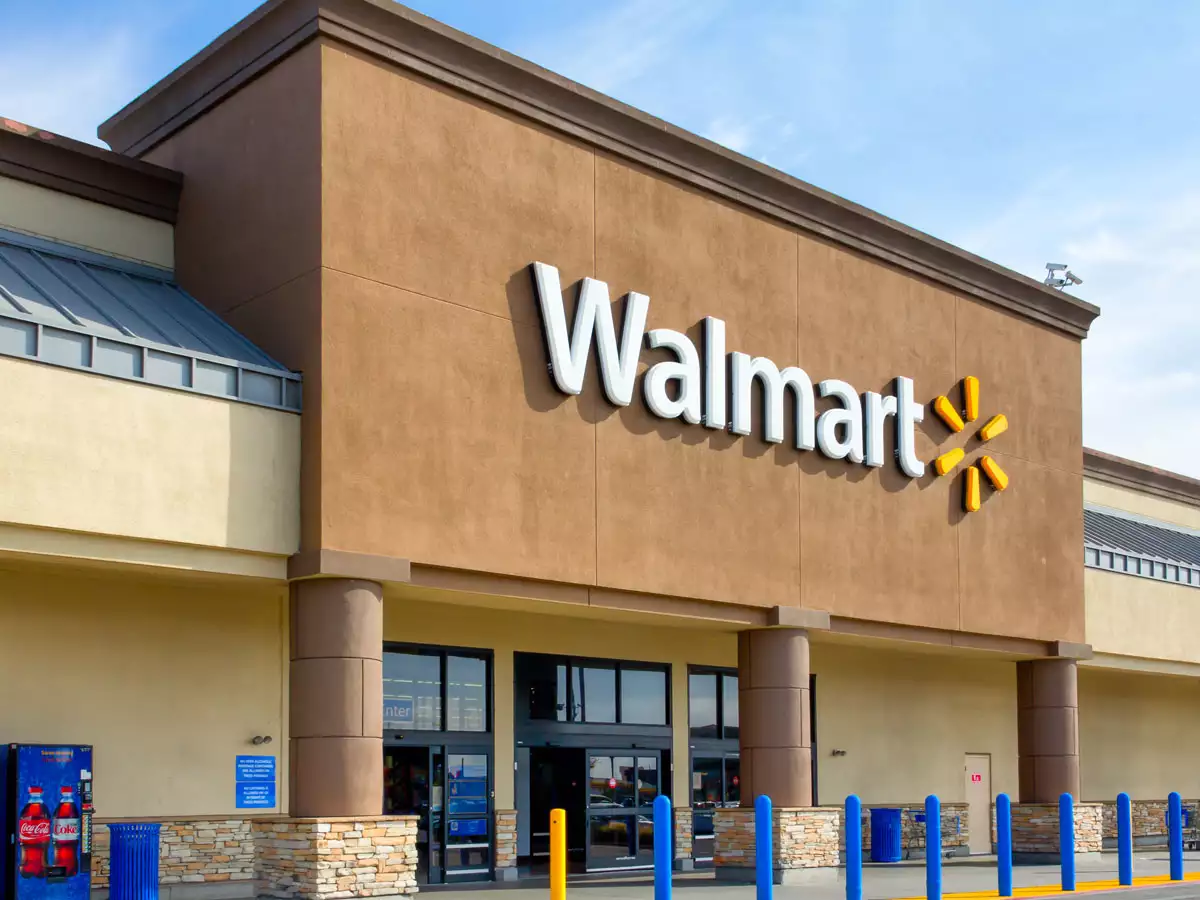

In [ ]:
!pip install opendatasets --q

TIP #1: Create an outline for your notebook & for each section before you start coding

#### Here's an outline of the project:

- Download the dataset
- Explore & analyze the dataset
- Prepare the dataset for ML training
- Train hardcoded & baseline models
- Make predictions & submit to Kaggle
- Peform feature engineering
- Train & evaluate different models
- Tune hyperparameters for the best models
- Train on a GPU with the entire dataset
- Document & publish the project online

### Data Set
The [Walamart Data set](https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data) was taken from Kaggle data competion.It contains 421,570 rows and 18 columns ,the objective of the competition is to forecast the Weekly Sales based on the following
- Category store (size)
- Type of the store
- USA Department location
- Promotional info
- Date
- Holiday info
- Fuel Price
- Unemployment
- CPI Consumer Price Index

## important libraries
[Pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide)
- Pandas is an open-source, BSD-licensed
library for data analysis using Python. It provides high-performance, easy-to-use data structures and data analysis tools for working with structured (tabular, multidimensional, potentially heterogeneous) and time series data.

[Numpy](https://numpy.org/doc/1.20/user/whatisnumpy.html)
- NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.

[Matplotlib](https://pypi.org/project/matplotlib/)

- Matplotlib produces publication-quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, Python/IPython shells, web application servers, and various graphical user interface toolkits.

[Scikit - Learn](https://scikit-learn.org/stable/)
- Is a machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.





**Importing the necessary libraries and display setting to make it more visually friendly**

In [ ]:
# OS and Data libraries
import os
import opendatasets as od
from zipfile import ZipFile

#Data analysis libraries
import numpy as np
import pandas as pd

#Visualisation libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#date formatters
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

#Jupyter notebook visualisation font and figure display parameters
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

With the **OS** library, created by Jovian we could download any data kaggle dataset directly. It's necesarry to have your username and the the API credentials.

In [ ]:
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting')
os.listdir('walmart-recruiting-store-sales-forecasting')

100%|██████████| 2.70M/2.70M [00:01<00:00, 2.14MB/s]


Extracting archive ./walmart-recruiting-store-sales-forecasting/walmart-recruiting-store-sales-forecasting.zip to ./walmart-recruiting-store-sales-forecasting


['train.csv.zip',
 'test.csv.zip',
 'features.csv.zip',
 'sampleSubmission.csv.zip',
 'stores.csv']

In [ ]:
!ls -lh

total 12K
-rw-r--r-- 1 root root   67 Oct 15 09:37 kaggle.json
drwxr-xr-x 1 root root 4.0K Oct 12 13:25 sample_data
drwxr-xr-x 2 root root 4.0K Oct 15 09:37 walmart-recruiting-store-sales-forecasting


### Structure
The data is mainly divided into 5 csv files:
1. Features: This file contains additional data related to the store, department, and regional activity for the given dates
2. Test: The same info withheld the Weekly Sales
3. Traing: This is the historical training data, which covers to 2010-02-05 to 2012-11-01.
4. Stores: This file contains anonymized information about the 45 stores, indicating the type and size of store.
5. Sample: The file to write the final predictions

### Merge features and Store for the training and test data

Now we create the path in a variable and use the f string formar to build the DataFrames for all the csv files.

In [ ]:
path= ('./walmart-recruiting-store-sales-forecasting/')

features_df = pd.read_csv(f'{path}features.csv.zip')
test_df = pd.read_csv(f'{path}test.csv.zip')
train_df = pd.read_csv(f'{path}train.csv.zip')
stores_df = pd.read_csv(f'{path}stores.csv')
sample_df=pd.read_csv(f'{path}sampleSubmission.csv.zip')

Lets merge the DataFrames:

- First, we should merge the train_df with features
- Now, merge with the stores_df

In [ ]:
df_raw = pd.merge(train_df, features_df, how = 'inner' ,on = ['Store','Date','IsHoliday']).sort_values(
    by=['Store','Dept','Date']).reset_index(drop=True).merge(stores_df, on='Store',how='inner')

Let's view a statistic summary of the merged *DataFrame*

In [ ]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw['Week'] = df_raw['Date'].dt.week
df_raw['Year'] = df_raw['Date'].dt.year

<ipython-input-7-052a070edde3>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_raw['Week'] = df_raw['Date'].dt.week


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

### Note:
.T: This is used to transpose the resulting DataFrame. Transposing a DataFrame essentially swaps its rows and columns. So, if the original DataFrame has columns as rows and vice versa after transposing.

In [ ]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,150681.0,7246.420196,8291.221345,0.270,2240.270000,5347.45000,9210.900000,88646.760000
MarkDown2,111248.0,3334.628621,9475.357325,-265.760,41.600000,192.00000,1926.940000,104519.540000
MarkDown3,137091.0,1439.421384,9623.078290,-29.100,5.080000,24.60000,103.990000,141630.610000
MarkDown4,134967.0,3383.168256,6292.384031,0.220,504.220000,1481.31000,3595.040000,67474.850000
MarkDown5,151432.0,4628.975079,5962.887455,135.160,1878.440000,3359.45000,5563.800000,108519.280000


We set the Date aas the Index for the df_raw

In [ ]:
df_raw.set_index(keys='Date',inplace =True)

It's neccesary to check the missing values for each columns.

In [ ]:
percent_missing = (df_raw.isna().sum() * 100 /len(df_raw)).round(2)
percent_missing

Store            0.00
Dept             0.00
Weekly_Sales     0.00
IsHoliday        0.00
Temperature      0.00
Fuel_Price       0.00
MarkDown1       64.26
MarkDown2       73.61
MarkDown3       67.48
MarkDown4       67.98
MarkDown5       64.08
CPI              0.00
Unemployment     0.00
Type             0.00
Size             0.00
Week             0.00
Year             0.00
dtype: float64

<ipython-input-12-47e2ad0df0f0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_raw.corr(),vmax=.3,center=0,square=True,linewidths=5,cbar_kws={'shrink':.5},annot=True);


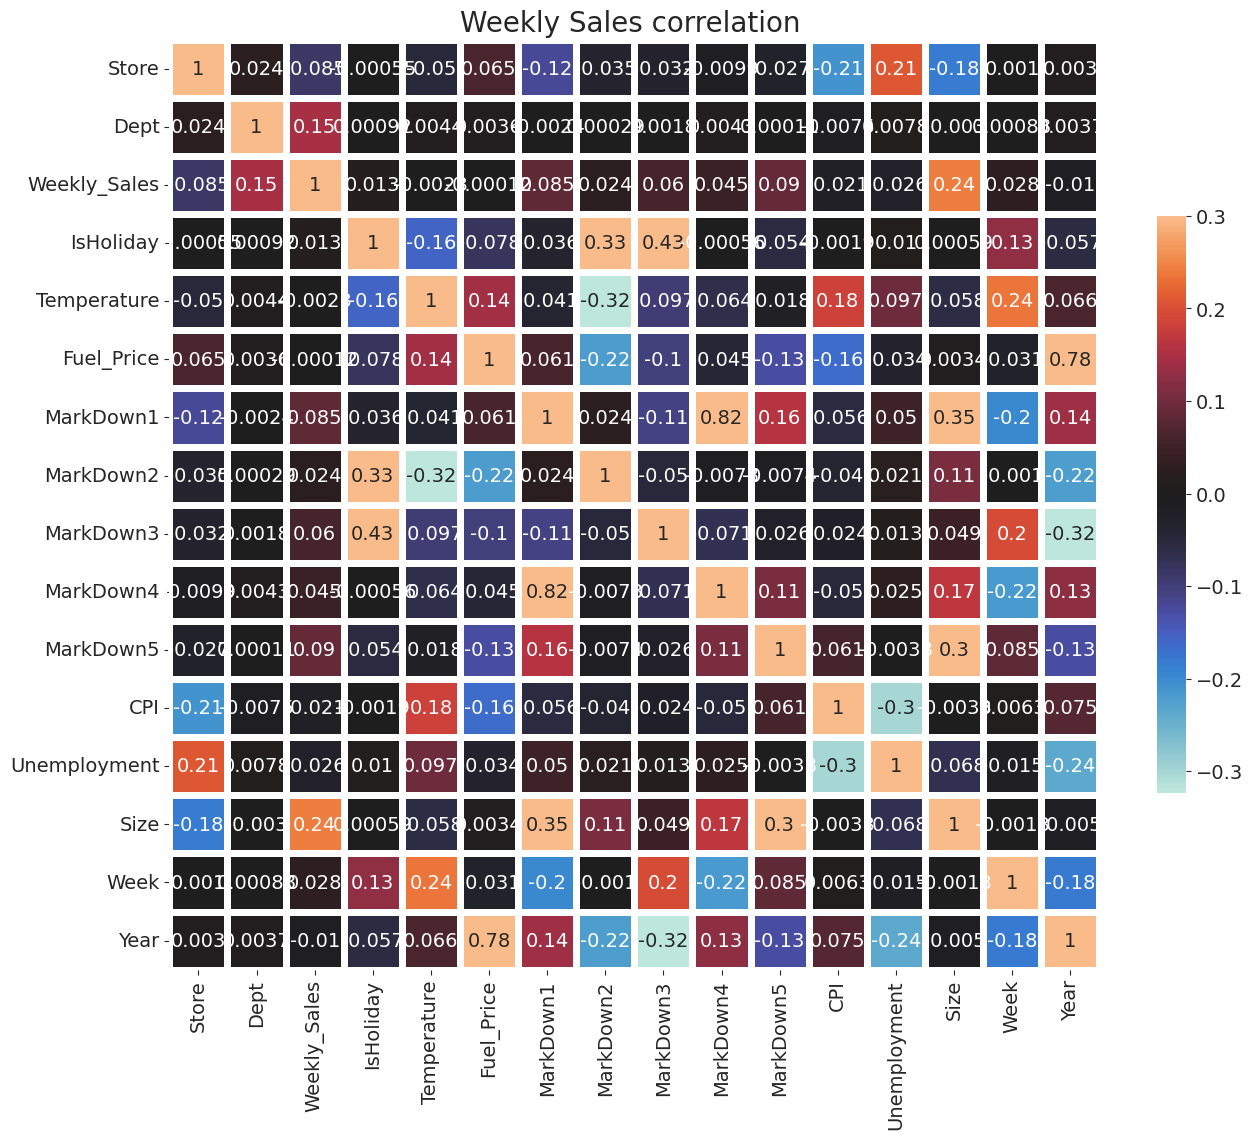

In [ ]:
plt.subplots(figsize=(15,15));
plt.title('Weekly Sales correlation ', fontsize=20);
sns.heatmap(df_raw.corr(),vmax=.3,center=0,square=True,linewidths=5,cbar_kws={'shrink':.5},annot=True);

Lets see the correlation between Weekly_Sales and the rest of the variables.

In [ ]:
df_raw.corr().iloc[2,:].sort_values(ascending=False)

<ipython-input-13-81eef0e7f733>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_raw.corr().iloc[2,:].sort_values(ascending=False)


Weekly_Sales    1.000000
Size            0.243828
Dept            0.148032
MarkDown5       0.090362
MarkDown1       0.085251
MarkDown3       0.060385
MarkDown4       0.045414
Week            0.027673
MarkDown2       0.024130
IsHoliday       0.012774
Fuel_Price     -0.000120
Temperature    -0.002312
Year           -0.010111
CPI            -0.020921
Unemployment   -0.025864
Store          -0.085195
Name: Weekly_Sales, dtype: float64

- Dropping of the CPI,FUEL,PRICE,DEVELOPMENT and TEMPERATURE due to low correlation .
- Dropping oof the Markdowns columns due to most of them hae more half values are missing.

In [ ]:
df_raw.drop(axis = 1, columns = ["MarkDown1", "MarkDown2","MarkDown3",
                                 "MarkDown4", "MarkDown5", 'CPI',
                                'Fuel_Price',  'Unemployment','Temperature', 'Year', 'Store'], inplace = True)

In [ ]:
df_raw.head(10)

,Dept,Weekly_Sales,IsHoliday,Type,Size,Week
Date,,,,,,
2010-02-05,1,24924.50,False,A,151315,5
2010-02-12,1,46039.49,True,A,151315,6
2010-02-19,1,41595.55,False,A,151315,7
2010-02-26,1,19403.54,False,A,151315,8
2010-03-05,1,21827.90,False,A,151315,9
2010-03-12,1,21043.39,False,A,151315,10
2010-03-19,1,22136.64,False,A,151315,11
2010-03-26,1,26229.21,False,A,151315,12
2010-04-02,1,57258.43,False,A,151315,13


## EDA Insights On The Data

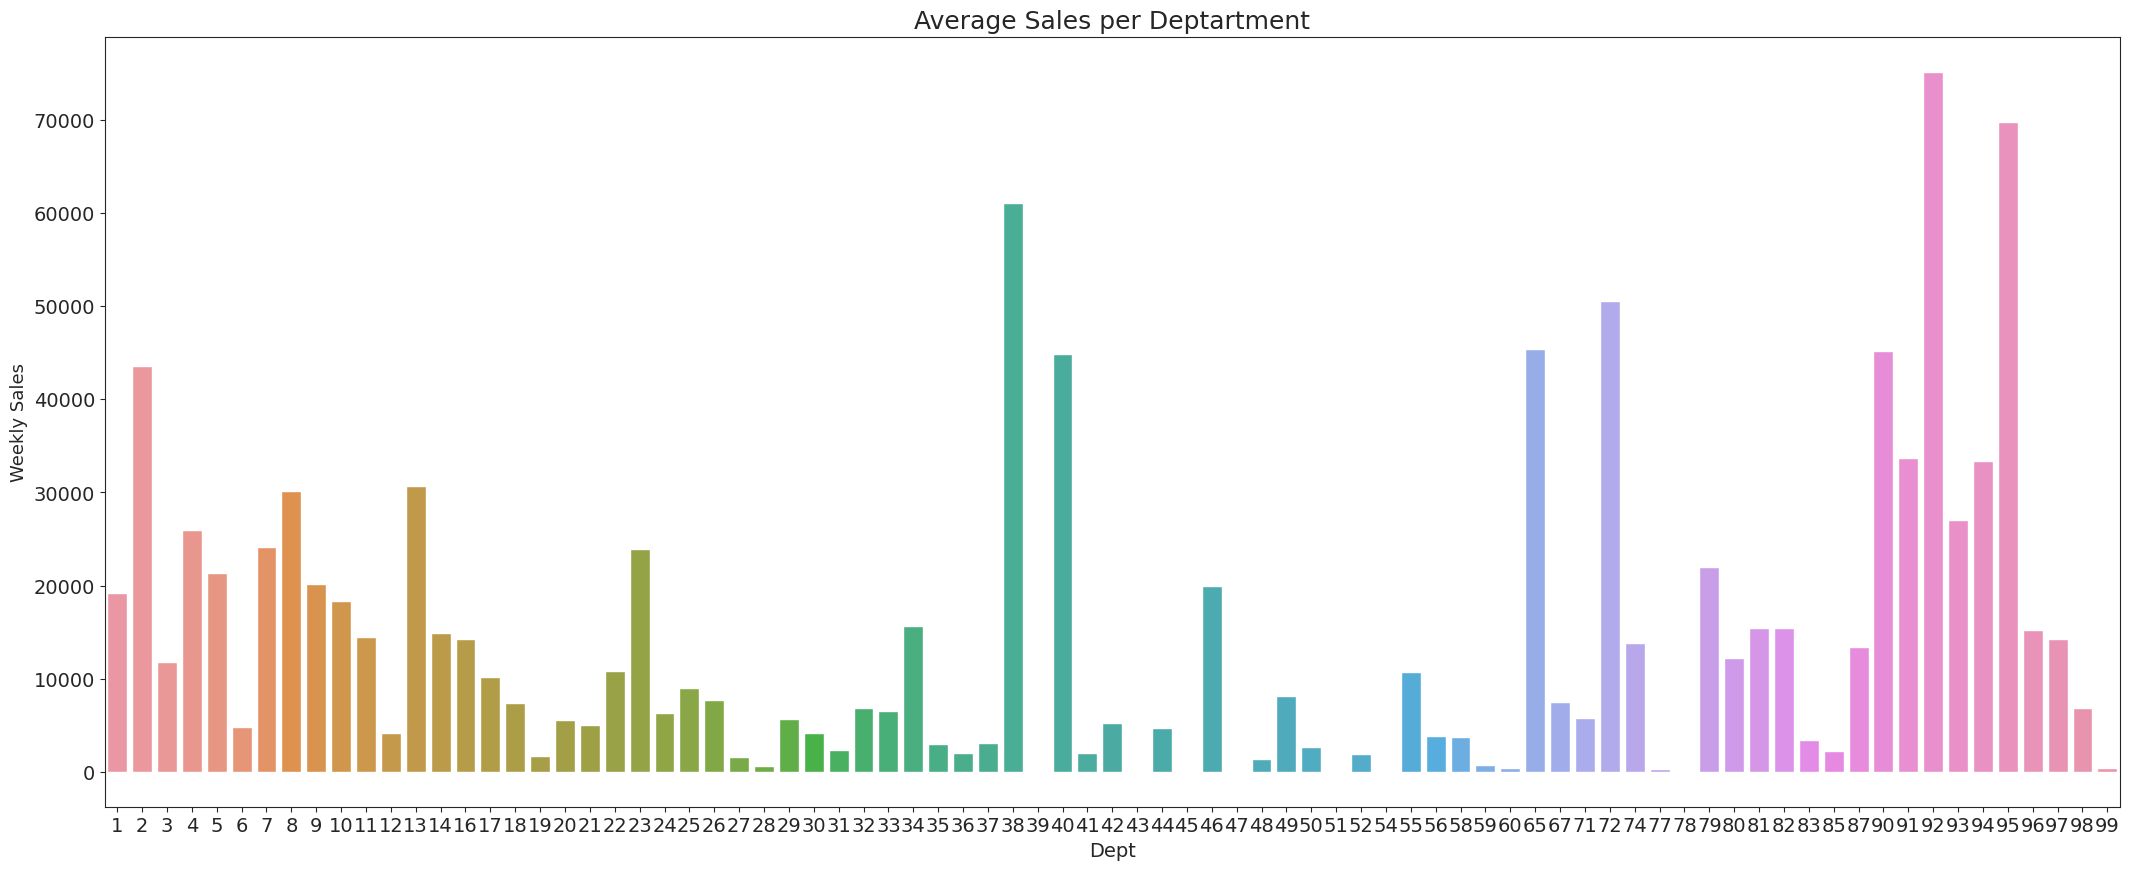

In [ ]:
sales_store = df_raw['Weekly_Sales'].groupby(df_raw['Dept']).mean()
plt.figure(figsize=(26,10))
plt.title("Average Sales per Deptartment",fontsize=18)
plt.ylabel("Weekly Sales", fontsize=13)
sns.barplot(x=sales_store.index,y=sales_store.values);

- As we can see dept 92 ,have the higest avg sales followed by dept 95 and the rest of the others.
- As it as less competiton and avg pepole staying there is more.

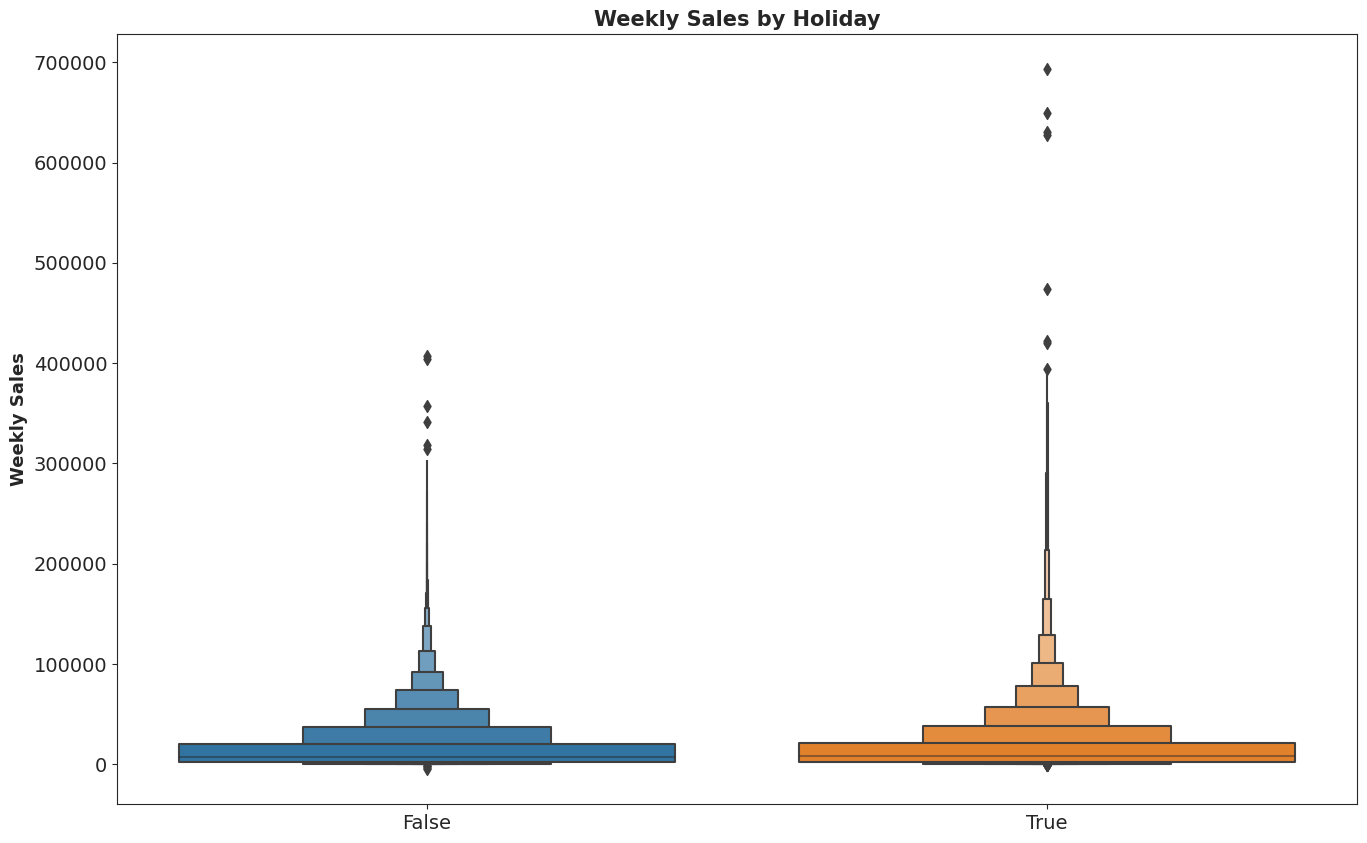

In [ ]:
plt.subplots(figsize=(16,10))
sns.boxenplot(y=df_raw['Weekly_Sales'], x=df_raw['IsHoliday'])
plt.ylabel("Weekly Sales", fontsize=13, fontweight='bold')
plt.xlabel(None)
plt.title('Weekly Sales by Holiday', fontweight='bold', fontsize=15);

The highest sales seems to be in the week of holidays and higest peak sales is around the Holiday around the week.

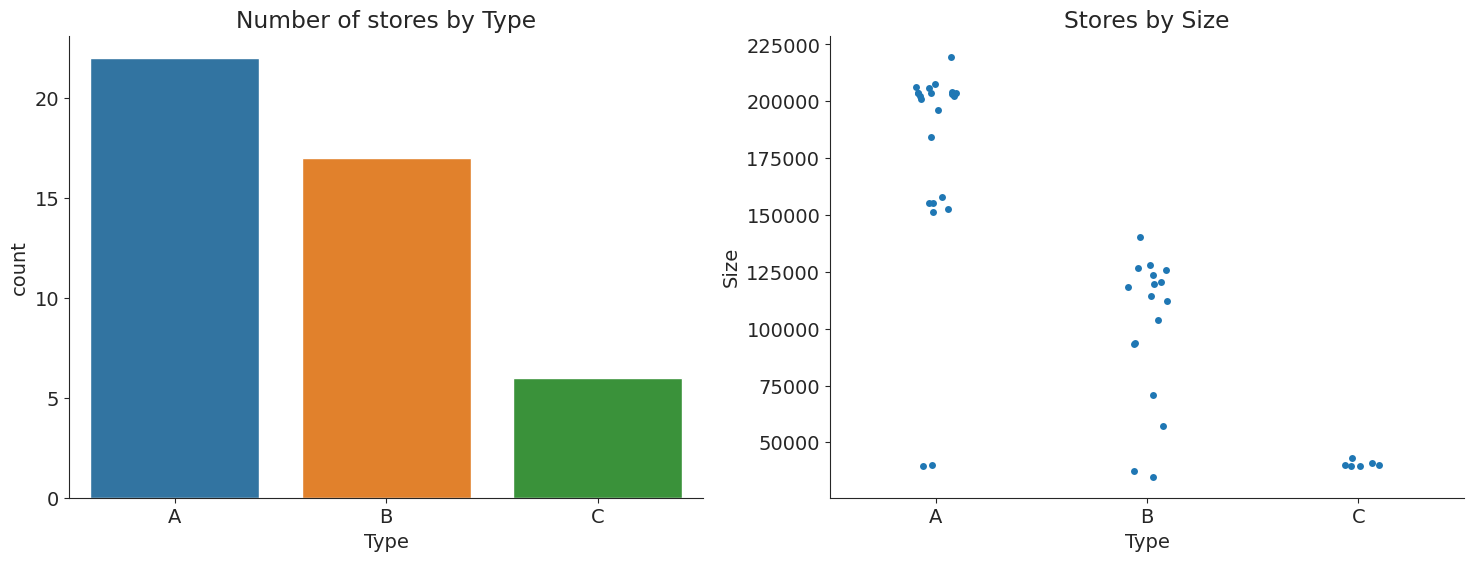

In [ ]:
fig,axes = plt.subplots(1,2,figsize= (18,6))
sns.countplot(data= stores_df,  x = "Type", ax=axes[0])
axes[0].set_title("Number of stores by Type")
sns.stripplot(x="Type", y= "Size", data= stores_df, ax = axes[1])
axes[1].set_title("Stores by Size")
sns.despine();

- Type A stores (Supercenters) are the largest of the three types (with a few exceptions)
- Type C stores (neighbourhood stores) are the smallest in size
- There are more stores of Type A (22) and very few stores of Type C(6)
- A few Type A (Supercenters) and B (discount stores) also have sizes similar to Type C (neighbourhood) stores

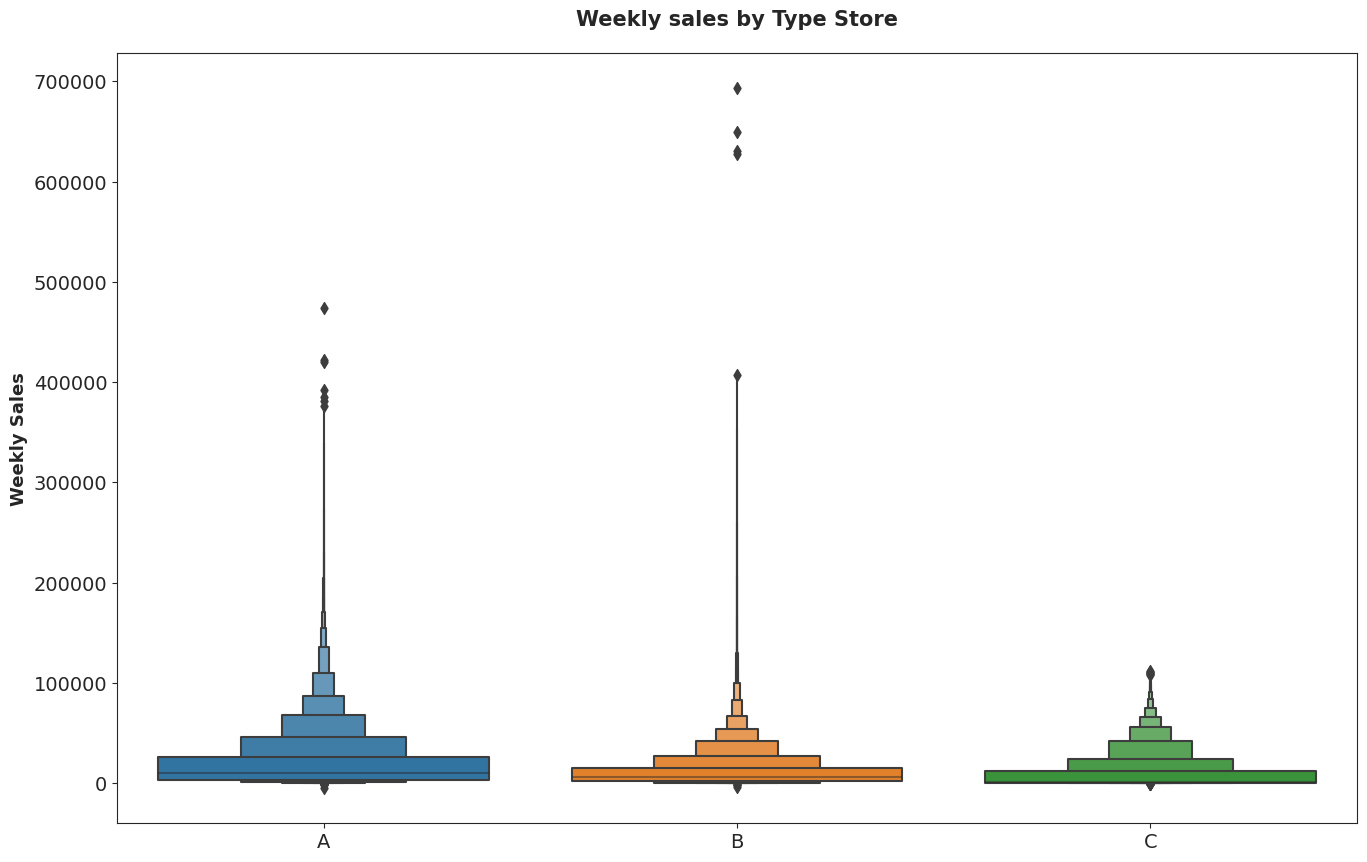

In [ ]:
plt.subplots(figsize=(16,10))
ax = sns.boxenplot(y=df_raw['Weekly_Sales'], x=df_raw['Type'])
plt.ylabel("Weekly Sales", fontsize=13, fontweight='bold')
plt.xlabel(None)
plt.title('Weekly sales by Type Store' , fontsize=15, fontweight='bold', pad=20);

- Type B have high fluctuation in sales compare to Type A and Type C.
- Type C have less sales also compare to Type A and Type B.

# Data cleaning and Preparation.

Now the data must be seprated by inputs and targets and creating a copy.

In [ ]:
inputs_df = df_raw[df_raw.columns.difference(['Weekly_Sales'])].copy()
targets = df_raw['Weekly_Sales'].copy()

In [ ]:
targets.describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

**The targets have two statistical issues:**

- There are negative values, no sense of it
- The Standard Deviation is too high, which means the data has outliers to be corrected

In [ ]:
#We should take the absolute values
targets = abs(targets)

In [ ]:
targets.describe()

count    421570.000000
mean      15981.676377
std       22710.889199
min           0.000000
25%        2079.757500
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

**Data prepartion**
- The SciKit-Learn allows us to split the data basically in two, the training and validatation data, also we could select the percentage of it.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs_df,
                                                                        targets,
                                                                        test_size=0.35)

With the split data we should make modifications to perform the model:

- MinMaxScaler: Takes the min and max values for the numerical columns and transforms the inputs in order to normalize the data.
- OneHotEncoder: Converts all the categorical columns into dummies in order to be integrated into the model.
- SimpleImputer: Removes the missing values and replaces them with the column mean or other strategy wishes.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

In [ ]:
inputs_df

,Dept,IsHoliday,Size,Type,Week
Date,,,,,
2010-02-05,1,False,151315,A,5
2010-02-12,1,True,151315,A,6
2010-02-19,1,False,151315,A,7
2010-02-26,1,False,151315,A,8
2010-03-05,1,False,151315,A,9
...,...,...,...,...,...
2012-09-28,98,False,118221,B,39
2012-10-05,98,False,118221,B,40
2012-10-12,98,False,118221,B,41


**Creating the list of categorical columns**

In [ ]:
categorical_cols = ['IsHoliday', 'Type', 'Week', 'Dept']

- We must fit the preprocessing tools with the data and then perform the changes.
- This must be done separte for the training data and validation data.

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

# Process the training data
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols]);

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-26-155c041dcc93>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols]);
<ipython-input-26-155c041dcc93>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_c

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(val_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols));

# Process the training data
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols]);

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-27-c5b69d15c51d>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols]);
<ipython-input-27-c5b69d15c51d>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_inputs[encoded_cols] =

Now **dropping** the orginal columns due to categorical coulmns that have been created.

In [ ]:
train_inputs.drop(['IsHoliday', 'Type', 'Week', 'Dept'], axis=1, inplace=True)
val_inputs.drop(['IsHoliday', 'Type', 'Week', 'Dept'], axis=1, inplace=True)

***In this project we are going to apply regression models, where we seek to a numerical target. Different from the classification models, since the latter are based on predicting the probability of two events.***

- **Linear Ridge:**


> Ridge Regression helps when predictors are highly correlated (multicollinearity problem). It penalizes the squares of regression coefficients but doesn’t allow the coefficients to reach zeros (uses L2 regularization).

- **Decision Tree:**

> A decision tree is a flowchart-like tree structure, where each internal node (non-leaf node) denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (or terminal node) holds a value for the target variable.

- **Random Forest:**

> Random forest in an extention of the bagging algorithm which takes random data samples from the training dataset (with replacement), trains several models and averages predictions.

- **XGBOOST:**

> Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.



With the OneHotEncoder we can create easily the categorical coulmns previously selected.

In [ ]:
val_inputs.head()

,Size,IsHoliday_False,IsHoliday_True,Type_A,Type_B,Type_C,Week_1,Week_2,Week_3,Week_4,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-28,158114,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-08-03,103681,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-12-31,57197,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-09-28,93188,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-08-13,123737,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Linear Ridge

In [ ]:
 from sklearn.linear_model import Ridge
linear = Ridge(alpha=1.0)
linear.fit(train_inputs, train_targets)
linear.score(val_inputs, val_targets), linear.score(train_inputs, train_targets)

(0.6253522831722833, 0.630574141037231)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# RMSE SCORE
linear_train_rmse = mean_squared_error(linear.predict(train_inputs), train_targets, squared=False)
linear_val_rmse = mean_squared_error(linear.predict(val_inputs), val_targets, squared=False)
# R2 SCORE
linear_train_r2 = r2_score(linear.predict(train_inputs), train_targets)
linear_val_r2 = r2_score(linear.predict(val_inputs), val_targets)

print(f'Train RMSE: {linear_train_rmse:,.2f}, Validation RMSE: {linear_val_rmse:,.2f}')
print(f'Train R2: {linear_train_r2:,.2f}, Validation R2: {linear_val_r2:,.2f}')

Train RMSE: 13,752.29, Validation RMSE: 13,996.69
Train R2: 0.41, Validation R2: 0.40


Since the linear regression is not accurate , both scores shows a ver high loss model.

We are gona try decision tree model.

# Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(train_inputs, train_targets)
tree.score(val_inputs, val_targets), tree.score(train_inputs, train_targets)

(0.944748461195542, 0.988288894768088)

In [ ]:
# RMSE SCORE
tree_train_rmse = mean_squared_error(tree.predict(train_inputs), train_targets, squared=False)
tree_val_rmse = mean_squared_error(tree.predict(val_inputs), val_targets, squared=False)
# R2 SCORE
tree_train_r2 = r2_score(tree.predict(train_inputs), train_targets)
tree_val_r2 = r2_score(tree.predict(val_inputs), val_targets)

print(f'Train RMSE: {tree_train_rmse:,.2f}, Validation RMSE: {tree_val_rmse:,.2f}')
print(f'Train R2: {tree_train_r2:,.2f}, Validation R2: {tree_val_r2:,.2f}')

Train RMSE: 2,448.56, Validation RMSE: 5,375.09
Train R2: 0.99, Validation R2: 0.94


This model seems to be having better accuracy than the perivous one,lets check with the RMSE model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf1 = RandomForestRegressor(random_state=42, n_jobs=-1)
rf1.fit(train_inputs, train_targets)
rf1.score(val_inputs, val_targets), rf1.score(train_inputs, train_targets)

(0.9508941365242163, 0.9857148659329068)

In [ ]:
# RMSE SCORE
rf1_train_rmse = mean_squared_error(rf1.predict(train_inputs), train_targets, squared=False)
rf1_val_rmse = mean_squared_error(rf1.predict(val_inputs), val_targets, squared=False)
# R2 SCORE
rf1_train_r2 = r2_score(rf1.predict(train_inputs), train_targets)
rf1_val_r2 = r2_score(rf1.predict(val_inputs), val_targets)

print(f'Train RMSE: {rf1_train_rmse:,.2f}, Validation RMSE: {rf1_val_rmse:,.2f}')
print(f'Train R2: {rf1_train_r2:,.2f}, Validation R2: {rf1_val_r2:,.2f}')

Train RMSE: 2,704.29, Validation RMSE: 5,067.34
Train R2: 0.99, Validation R2: 0.95


Using the RMSE both scores looks fine and accurate.

## XG-BOOST

In [ ]:
from xgboost import XGBRegressor
# XGBOOST Regressor
XGBmodel = XGBRegressor(
                        n_jobs=-1, random_state=42)
XGBmodel.fit(train_inputs, train_targets)
XGBmodel.score(train_inputs, train_targets), XGBmodel.score(val_inputs, val_targets)

(0.9262392042230151, 0.9186169069516407)

In [ ]:
# RMSE SCORE
XGBmodel_train_rmse = mean_squared_error(XGBmodel.predict(train_inputs), train_targets, squared=False)
XGBmodel_val_rmse = mean_squared_error(XGBmodel.predict(val_inputs), val_targets, squared=False)
# R2 SCORE
XGBmodel_train_r2 = r2_score(XGBmodel.predict(train_inputs), train_targets)
XGBmodel_val_r2 = r2_score(XGBmodel.predict(val_inputs), val_targets)

print(f'Train RMSE: {XGBmodel_train_rmse:,.2f}, Validation RMSE: {XGBmodel_val_rmse:,.2f}')
print(f'Train R2: {XGBmodel_train_r2:,.2f}, Validation R2: {XGBmodel_val_r2:,.2f}')

Train RMSE: 6,145.03, Validation RMSE: 6,523.50
Train R2: 0.91, Validation R2: 0.90


Using **XGBOOST** model the accuracy and the loss scored are ok but RMSE was still more accurate.

***Let's see graphically the best main hyperparameters. Due to the complexity of the model calculations request a long time, it only be shown the XBOOST graphic parameters because it got better results than Random Forest:***

In [ ]:
def test_params(**params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

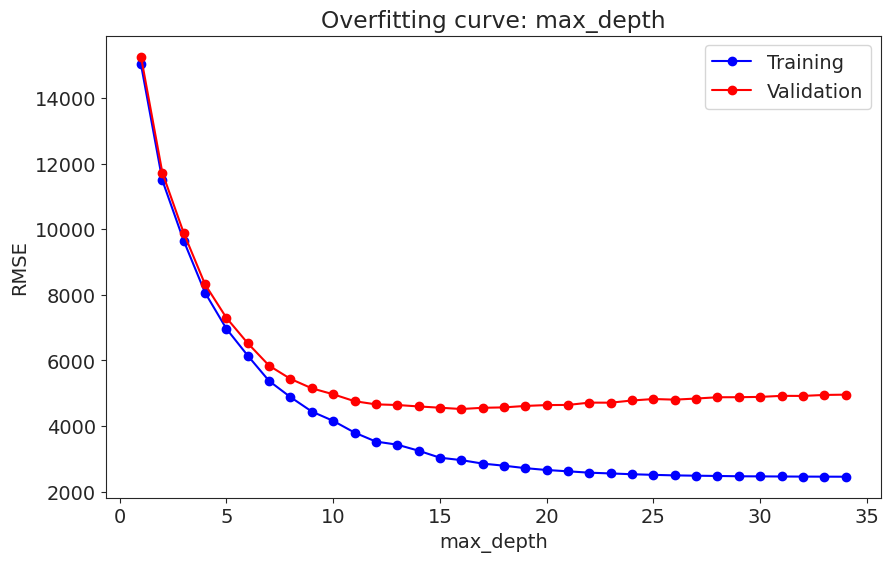

In [ ]:
test_param_and_plot('max_depth', range(1,35))

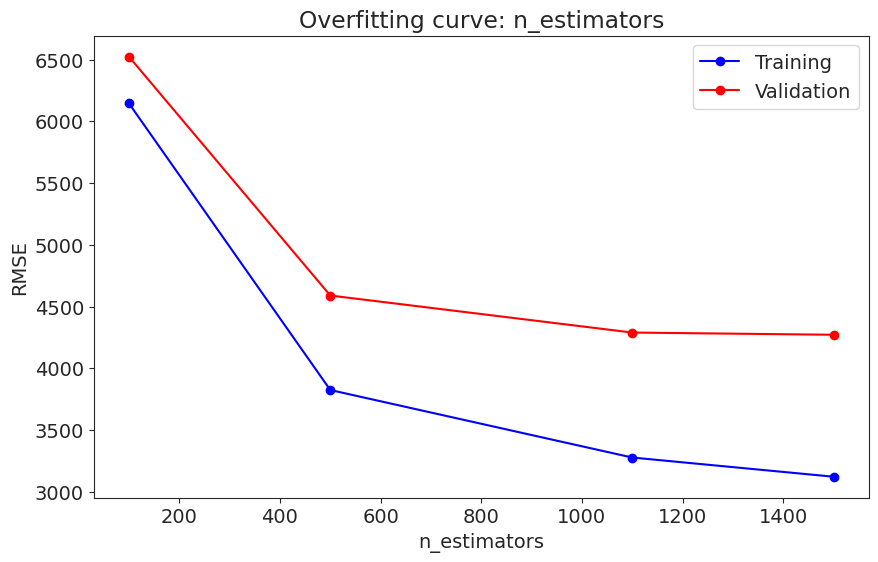

In [ ]:
test_param_and_plot('n_estimators',[100,500,1100, 1500])

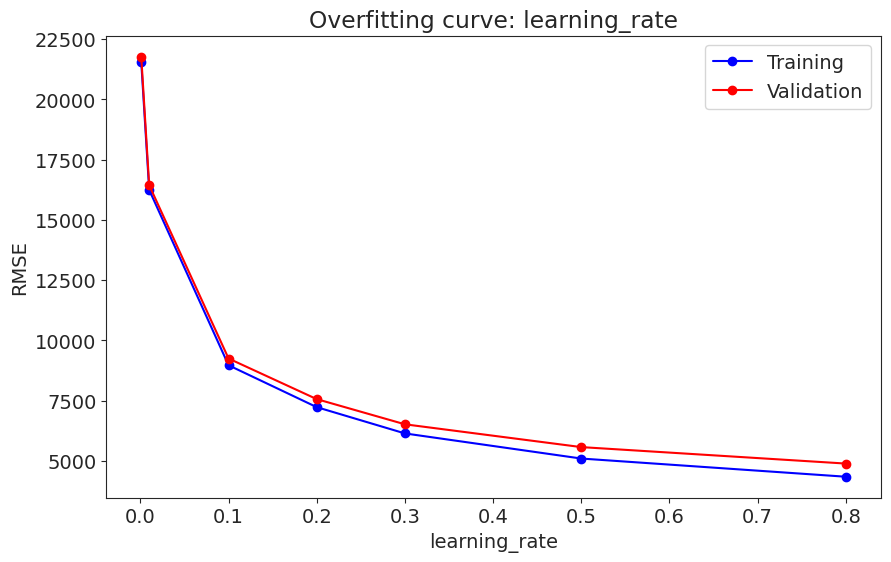

In [ ]:
test_param_and_plot('learning_rate',[0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.8])

# XGBOOST Tuned

In [ ]:
# XGBOOST Regressor
XGB_tuned = XGBRegressor(learning_rate = 0.3, n_estimators=750,
                        n_jobs=-1, random_state=42, max_depth=13,
                         booster='gbtree')

XGB_tuned.fit(train_inputs, train_targets)
XGB_tuned.score(train_inputs, train_targets), XGBmodel.score(val_inputs, val_targets)

(0.9879107909017115, 0.9186169069516407)

In [ ]:
# RMSE SCORE
XGB_tuned_train_rmse = mean_squared_error(XGB_tuned.predict(train_inputs), train_targets, squared=False)
XGB_tuned_val_rmse = mean_squared_error(XGB_tuned.predict(val_inputs), val_targets, squared=False)
# R2 SCORE
XGB_tuned_train_r2 = r2_score(XGB_tuned.predict(train_inputs), train_targets)
XGB_tuned_val_r2 = r2_score(XGB_tuned.predict(val_inputs), val_targets)
print(f'Train RMSE: {XGB_tuned_train_rmse:,.2f}, Validation RMSE: {XGB_tuned_val_rmse:,.2f}')
print(f'Train R2: {XGB_tuned_train_r2:,.2f}, Validation R2: {XGB_tuned_val_r2:,.2f}')

Train RMSE: 2,487.77, Validation RMSE: 4,687.52
Train R2: 0.99, Validation R2: 0.96


In [ ]:
XGB_tuned_importance = XGB_tuned.feature_importances_

In [ ]:
XGB_tuned_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': XGB_tuned_importance
}).sort_values('importance', ascending=False)

In [ ]:
XGB_tuned_importance_df.head(10)

,feature,importance
134,Dept_95,0.088334
131,Dept_92,0.072205
94,Dept_38,0.063899
59,Dept_2,0.058039
129,Dept_90,0.047841
96,Dept_40,0.042896
65,Dept_8,0.037590
61,Dept_4,0.030423
70,Dept_13,0.030070
133,Dept_94,0.029856


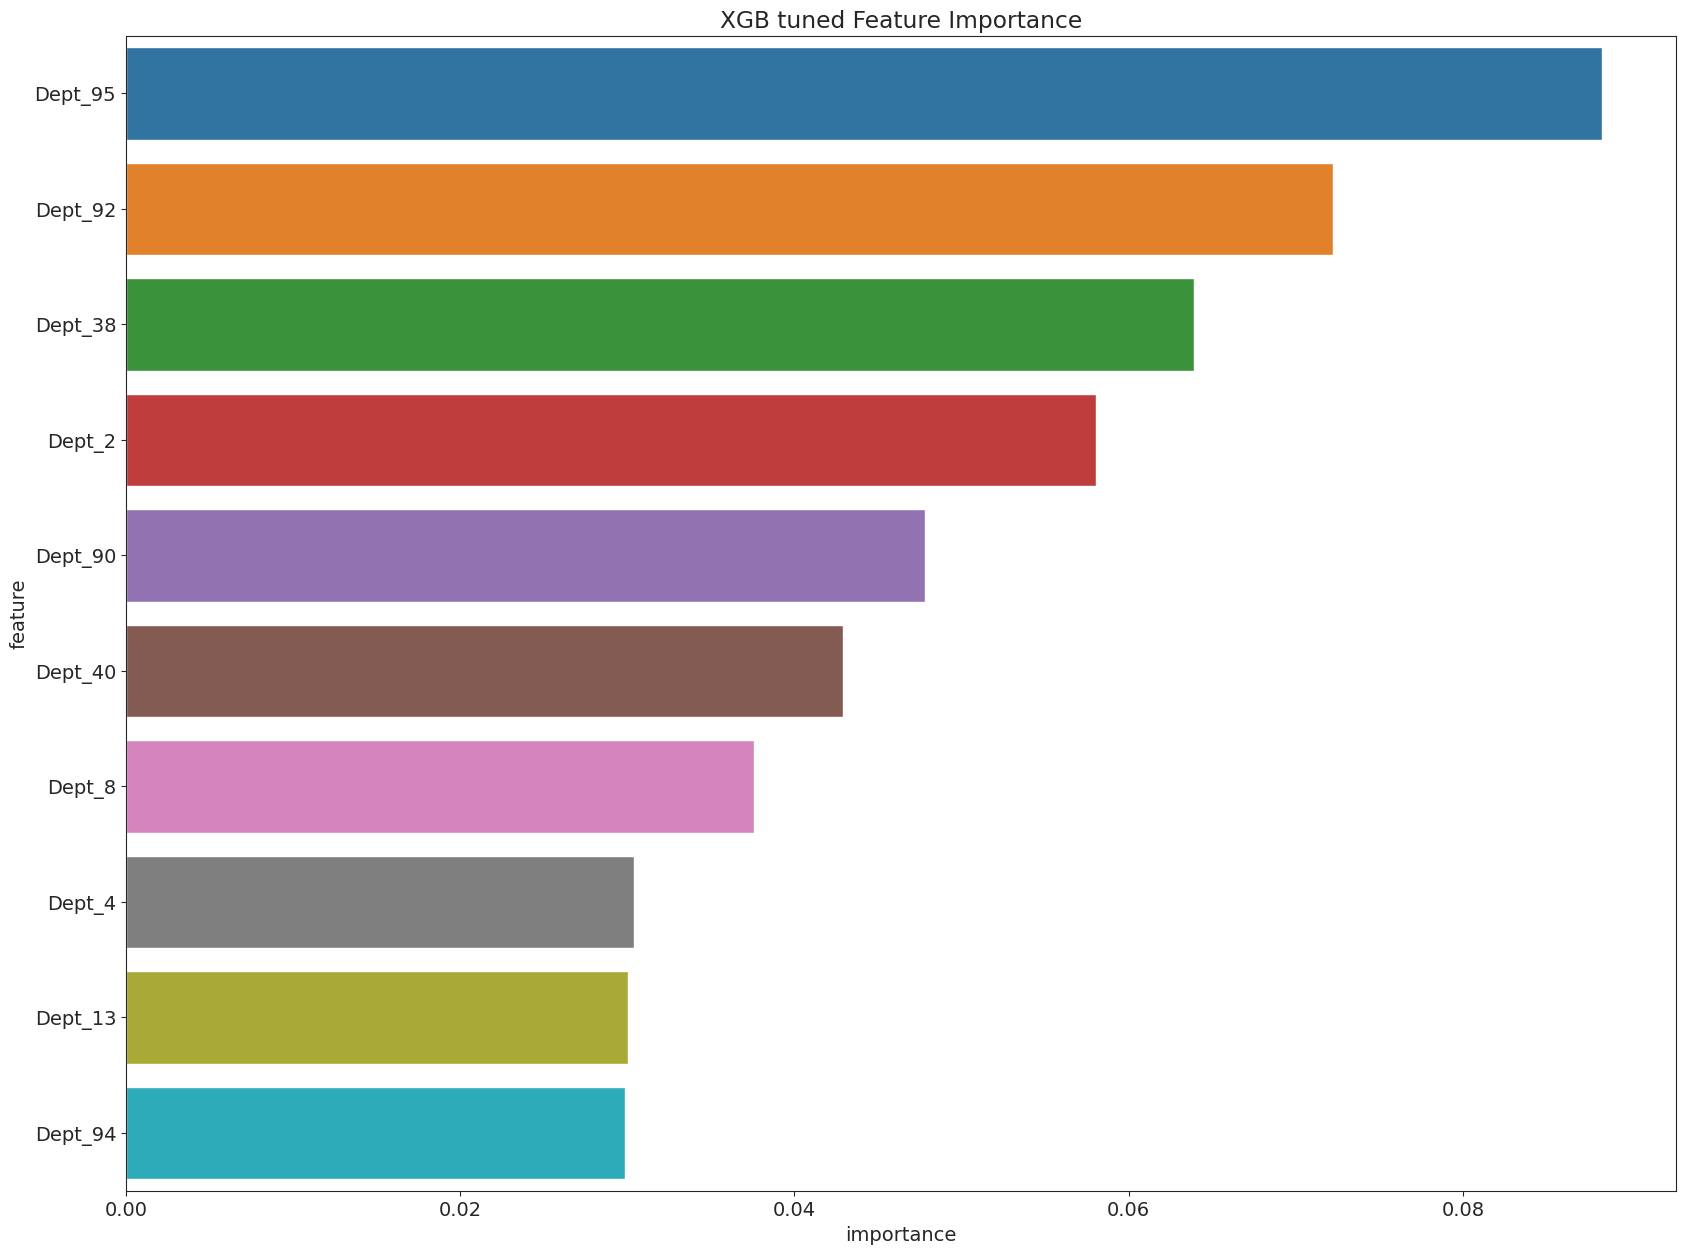

In [ ]:
plt.subplots(figsize=(20, 15))

plt.title('XGB tuned Feature Importance')
sns.barplot(data=XGB_tuned_importance_df.head(10), x='importance', y='feature');

In [ ]:
test_raw = pd.merge(test_df, features_df, how = 'inner' ,on = ['Store','Date','IsHoliday']).sort_values(
    by=['Store','Dept','Date']).reset_index(drop=True).merge(stores_df, on='Store',how='inner')

In [ ]:
test_raw['Date'] = pd.to_datetime(test_raw['Date'])
test_raw['Week'] = test_raw['Date'].dt.week

<ipython-input-50-ccad08fceac4>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_raw['Week'] = test_raw['Date'].dt.week


In [ ]:
test_raw

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,44
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,45
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,46
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,47
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,B,118221,26
115060,45,98,2013-07-05,False,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,B,118221,27
115061,45,98,2013-07-12,False,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,B,118221,28
115062,45,98,2013-07-19,False,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,B,118221,29


In [ ]:
test_raw.drop(axis = 1, columns = ["MarkDown1", "MarkDown2","MarkDown3",
                                 "MarkDown4", "MarkDown5", 'CPI',
                                'Fuel_Price',  'Unemployment','Temperature', 'Store'], inplace = True)

In [ ]:
test_raw[encoded_cols] = encoder.transform(test_raw[categorical_cols])

<ipython-input-53-ff1c9567e270>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_raw[encoded_cols] = encoder.transform(test_raw[categorical_cols])
<ipython-input-53-ff1c9567e270>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_raw[encoded_cols] = encoder.transform(test_raw[categorical_cols])
<ipython-input-53-ff1c9567e270>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [ ]:
test_raw.set_index(keys='Date', inplace=True)
test_raw.drop(['IsHoliday', 'Type', 'Week', 'Dept'], axis=1, inplace=True)

In [ ]:
test_raw

,Size,IsHoliday_False,IsHoliday_True,Type_A,Type_B,Type_C,Week_1,Week_2,Week_3,Week_4,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-02,151315,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-09,151315,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-16,151315,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-23,151315,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-30,151315,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-28,118221,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-07-05,118221,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-07-12,118221,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
test_data_pred = (XGB_tuned.predict(test_raw))

In [ ]:
sample_df['Weekly_Sales'] = test_data_pred

In [ ]:
sample_df

,Id,Weekly_Sales
0,1_1_2012-11-02,37589.347656
1,1_1_2012-11-09,19253.710938
2,1_1_2012-11-16,17869.703125
3,1_1_2012-11-23,20209.281250
4,1_1_2012-11-30,25036.082031
...,...,...
115059,45_98_2013-06-28,140.011383
115060,45_98_2013-07-05,636.248901
115061,45_98_2013-07-12,370.603333
115062,45_98_2013-07-19,536.173218


In [ ]:
sample_df.to_csv('Wallmart4.csv',index=False)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('Wallmart4.csv')

/content/Wallmart4.csv

# Project Acknowledgement and insights
1. To avoid data leakage is imperative to split the data before the transformation.

2. The model accuracy is leverage on the categorical columns. The first models I tried used only with IsHoliday and Type as categorical variables, getting poor results and generic predictions for most of the test data.

3. Test your score accuracy using two kinds of scores.

4. The correlation is a good insight to select the variables, but nevertheless, it's really important to extrapolate the variables to reality and check if are essential inputs that can't be skipped.

5. Always try to detect data outliers, even in the target data. I tried to run models without modifying negative data on Weekly Sales, getting poor models.

6. The first model (Linear Ridge) showed a loss of 13,694.72 and we finished (XGB tuned) the model with a loss of 4,911.74 .



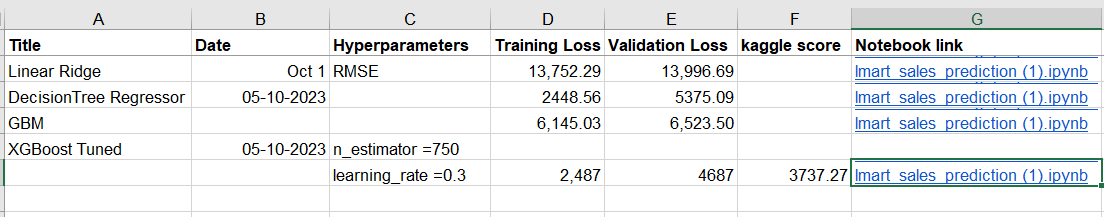

## Kaggle Competition Score

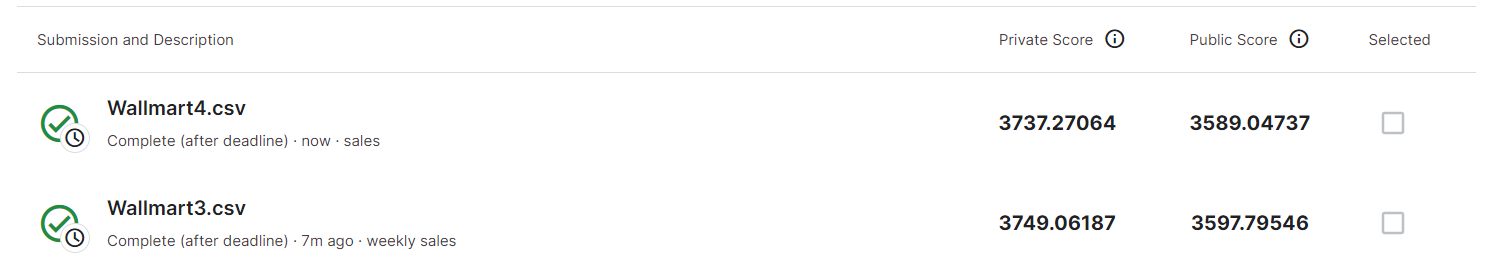

## Future Work Selection.


1. Tune the model with the library Optuna to set and upskill the hyperparameters.
2. Create a pipeline for easy understanding tuning
3. Perform the dates data for an optimum model.

## Reference


> - Aakash N.S Notebooks and lecture :75%


> - kaggle leaderboard coding :25%

### Other resources


**Documentations.**

Scikit Learn Supervised Learning [documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

XGBoost[documentation](https://xgboost.readthedocs.io/en/latest/)










